In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [145]:
def process_image(image_path, save_crops=False, visualize=True):
    # Wczytaj obraz
    image = cv2.imread(image_path)
    image = cv2.resize(image, (200, 100))

    # Konwersja obrazu na skalę szarości
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Zastosowanie filtru Otsu do progowania
    _, otsu_mask = cv2.threshold(
        gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Znajdź składowe połączone
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        otsu_mask, connectivity=8
    )

    # Znajdź składową połączoną z największym polem
    areas = stats[1:, cv2.CC_STAT_AREA]  # Pomiń pierwszy element, który jest tłem
    largest_component_index = np.argmax(areas) + 1  # Indeks największej składowej
    x, y, w, h = (
        stats[largest_component_index, cv2.CC_STAT_LEFT],
        stats[largest_component_index, cv2.CC_STAT_TOP],
        stats[largest_component_index, cv2.CC_STAT_WIDTH],
        stats[largest_component_index, cv2.CC_STAT_HEIGHT],
    )

    # Wytnij i odwróć obraz największej składowej
    otsu_mask = otsu_mask[y : y + h, x : x + w]
    otsu_mask_reversed = cv2.bitwise_not(otsu_mask)

    # Znajdź składowe połączone
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        otsu_mask_reversed, connectivity=8
    )
    
    areas = stats[0:, cv2.CC_STAT_AREA]
    mean_area = np.mean(areas)
    std_area = np.std(areas)
    
    
    lower_bound = mean_area*0.1 #- std_area #* 0.25
    upper_bound = mean_area*0.95 #+ std_area #* 0.5

    # Acceptable aspect ratio range
    min_aspect_ratio = 1.5
    max_aspect_ratio = 200
    
    # Acceptable centroid y-coordinate range
    min_y_coord = 15
    max_y_coord = 90
    
     # Acceptable centroid y-coordinate range
    min_x_coord = 5
    
    valid_area=[]
    for i in range(1, num_labels):
        x, y, w, h = (
            stats[i, cv2.CC_STAT_LEFT],
            stats[i, cv2.CC_STAT_TOP],
            stats[i, cv2.CC_STAT_WIDTH],
            stats[i, cv2.CC_STAT_HEIGHT],
        )
        aspect_ratio = h / w
        if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
            if min_y_coord <= centroids[i][1] <= max_y_coord and  min_x_coord<=centroids[i][0]:
                valid_area.append(stats[0:, cv2.CC_STAT_AREA])
    mean_area = np.mean(valid_area)
    std_area = np.std(valid_area)         

    # Znajdź i posortuj bounding boxy składowych połączonych według współrzędnej x
    filtered_components = []
    filtered_centroids = []
    for i in range(1, num_labels):
        x, y, w, h = (
            stats[i, cv2.CC_STAT_LEFT],
            stats[i, cv2.CC_STAT_TOP],
            stats[i, cv2.CC_STAT_WIDTH],
            stats[i, cv2.CC_STAT_HEIGHT],
        )
                    
        print("lb",lower_bound)
        print("area",stats[i, cv2.CC_STAT_AREA])
        print("ub",upper_bound)
        print("mean",mean_area)
        print("std",std_area)
        print()
        # print(x, y, w, h)
        if lower_bound <= stats[i, cv2.CC_STAT_AREA] <= upper_bound:
            aspect_ratio = h / w
            if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
                if (
                    centroids[i][0] >= x
                    and centroids[i][0] <= x + w
                    and centroids[i][1] >= y
                    and centroids[i][1] <= y + h
                ):
                    if min_y_coord <= centroids[i][1] <= max_y_coord and  min_x_coord<=centroids[i][0]:
                        
                        # print(centroids[i])

                        filtered_components.append((x, y, w, h))
                        filtered_centroids.append(centroids[i])

    filtered_components.sort()  # Sortuj według współrzędnej x

    # Wytnij i odwróć obrazy z maski
    cropped_masks = []
    for i, (x, y, w, h) in enumerate(filtered_components):
        cropped_mask = otsu_mask_reversed[y : y + h, x : x + w]
        cropped_mask_reversed = cv2.bitwise_not(cropped_mask)
        padding = 5  # Długość boku białego obszaru wokół wyciętego fragmentu
        padded_mask = np.zeros((h + 2 * padding, w + 2 * padding), dtype=np.uint8)
        padded_mask[padding : padding + h, padding : padding + w] = cropped_mask
        padded_mask = cv2.bitwise_not(padded_mask)
        cropped_masks.append(padded_mask)

        # Zapisz każdy wycięty obraz, jeśli opcja zapisu jest ustawiona na True
        if save_crops:
            if not os.path.exists("better_data/crop"):
                os.makedirs("better_data/crop")

            if not os.path.exists(
                "better_data/crop/" + image_path.split("/")[-1].split(".")[0]
            ):
                os.makedirs(
                    "better_data/crop/" + image_path.split("/")[-1].split(".")[0]
                )

            filename = (
                "better_data/crop/"
                + image_path.split("/")[-1].split(".")[0]
                + f"/crop_{i+1}.png"
            )
            # print(filename)
            cv2.imwrite(filename, padded_mask)

    # centroids = centroids[1:]
    filtered_centroids = np.array(filtered_centroids)
    y_coordinates = centroids[:, 1].reshape(-1, 1)

    dbscan = DBSCAN(
        eps=10, min_samples=8
    )  # Parametry eps (odległość) i min_samples (minimalna liczba punktów w klastrze)
    cluster_labels = dbscan.fit_predict(y_coordinates)

    clustered_image = np.zeros_like(gray_image)

    for i, (_, y) in enumerate(filtered_centroids):
        cluster_idx = cluster_labels[i]
        cv2.circle(
            clustered_image,
            (int(filtered_centroids[i][0]), int(y)),
            int(cluster_idx) + 4,
            int(cluster_idx) + 1,
            -1,
        )  # +1, aby uniknąć koloru tła

    # Opcjonalnie: Pokaż wyniki
    if visualize:
        print(image_path)
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 5, 1)
        plt.title("Oryginalny Obraz")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 5, 2)
        plt.title("Obraz w Skali Szarości")
        plt.imshow(gray_image, cmap="gray")

        plt.subplot(1, 5, 3)
        plt.title("Maska Otsu")
        plt.imshow(otsu_mask, cmap="gray")

        plt.subplot(1, 5, 4)
        plt.title("Odwrócona Maska Otsu")
        plt.imshow(otsu_mask_reversed, cmap="gray")

        plt.subplot(1, 5, 5)
        plt.imshow(clustered_image, cmap="jet")  # Użyj mapy kolorów 'jet'
        plt.title("Wyniki Klastrów")

        plt.show()

        # Wyświetl wycięte obrazy z odwróconej maski
        plt.figure(figsize=(20, 5))
        for i, cropped_mask in enumerate(cropped_masks):
            plt.subplot(1, len(cropped_masks), i + 1)
            plt.imshow(cropped_mask, cmap="gray")
            plt.title(f"Obszar {i+1}")
            plt.axis("off")

        plt.show()

lb 76.43529411764706
area 1935
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 45
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 251
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 281
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 268
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 333
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 244
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 316
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 452
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 2
ub 726.135294117647
mean 764.3529411764706
std 1645.8756632753089

lb 76.43529411764706
area 4
ub 7

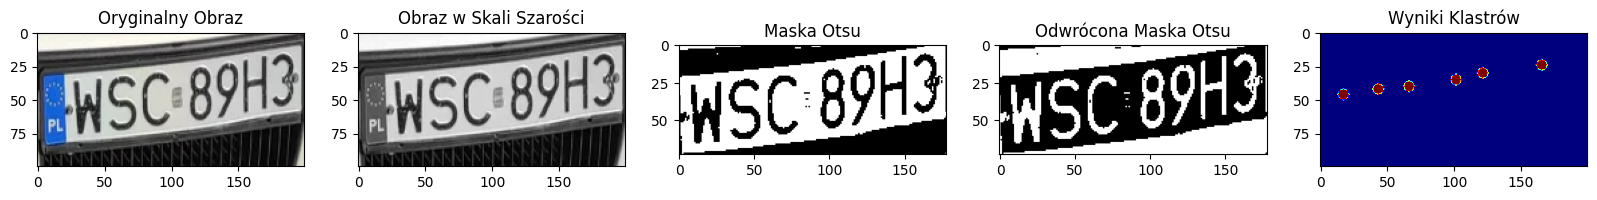

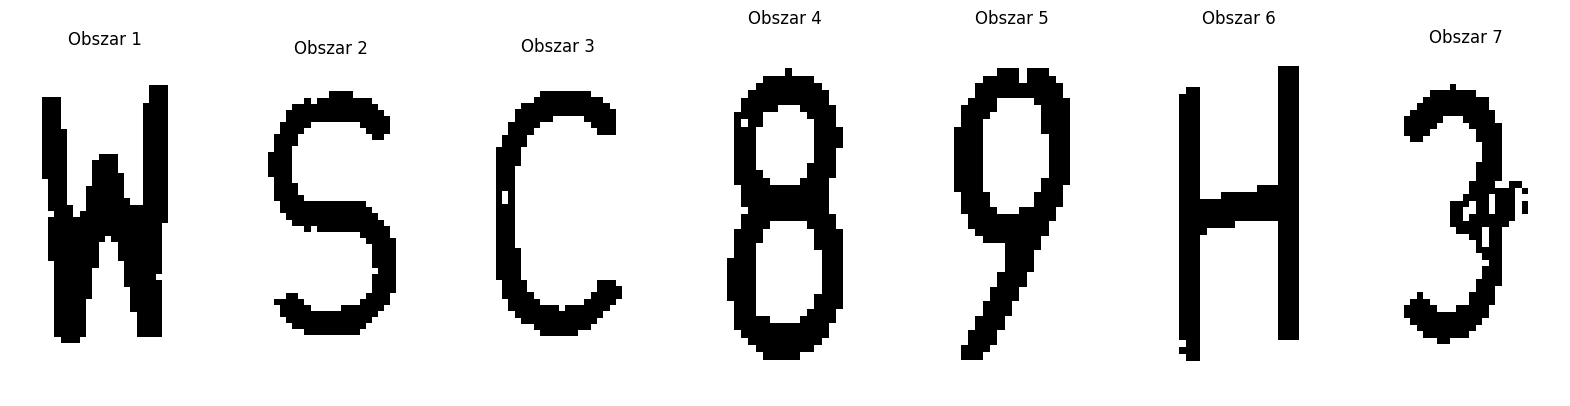

lb 60.03
area 219
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 4
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 1
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 437
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 275
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 389
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 458
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 356
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 184
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 270
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 523
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 1
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 202
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 7
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 4
ub 570.285
mean 600.3
std 1838.277974083354

lb 60.03
area 3
ub 570.285
mean 600.3
std 1838.277974083354

lb 6

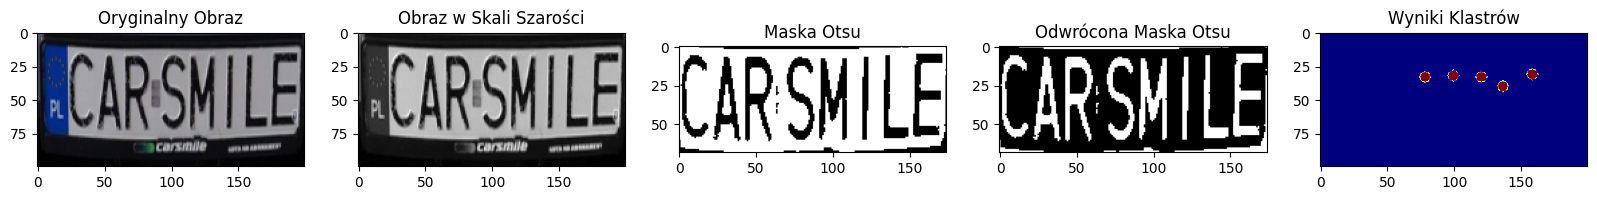

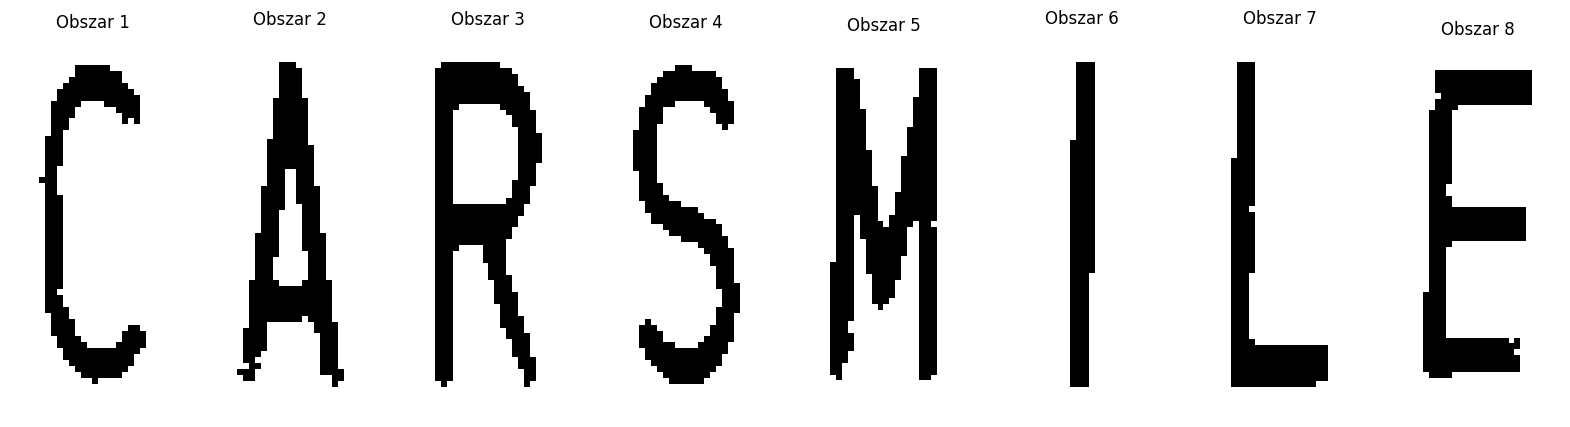

lb 77.7578947368421
area 37
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 679
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 413
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 523
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 435
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 458
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 416
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 384
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 398
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 178
ub 738.6999999999999
mean 777.578947368421
std 1972.3753597012885

lb 77.7578947368421
area 1802
ub 738.6999

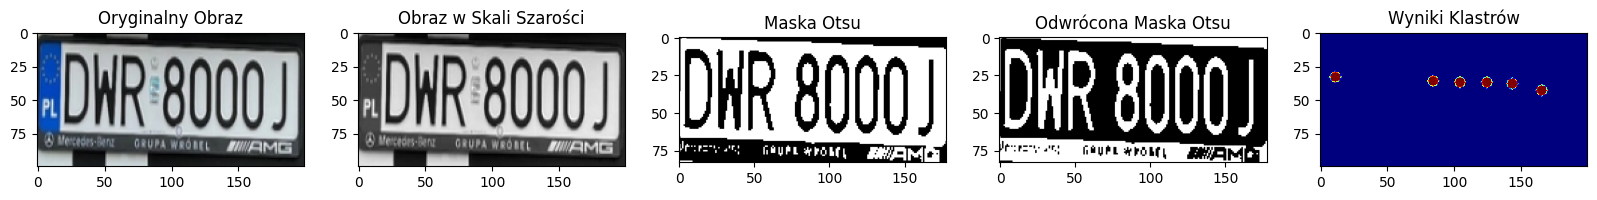

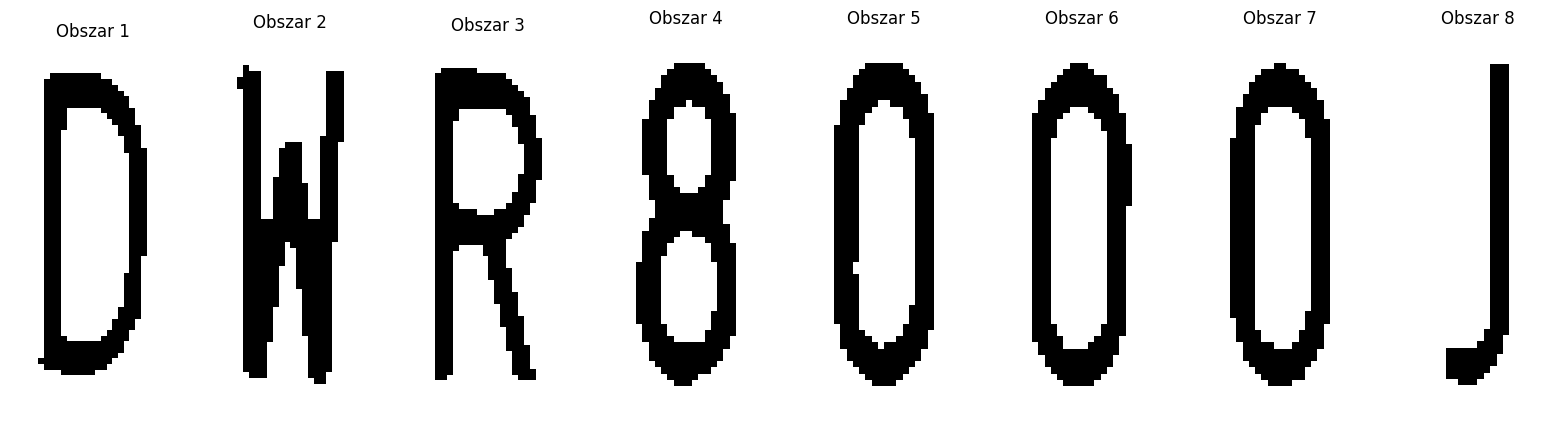

lb 52.25
area 876
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 276
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 489
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 344
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 340
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 175
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 309
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 389
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 400
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 146
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 2
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 1
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 11
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 7
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 47
ub 496.375
mean 522.5
std 1814.6731405801038

lb 52.25
area 14
ub 496.375
mean 522.5
std 1814.

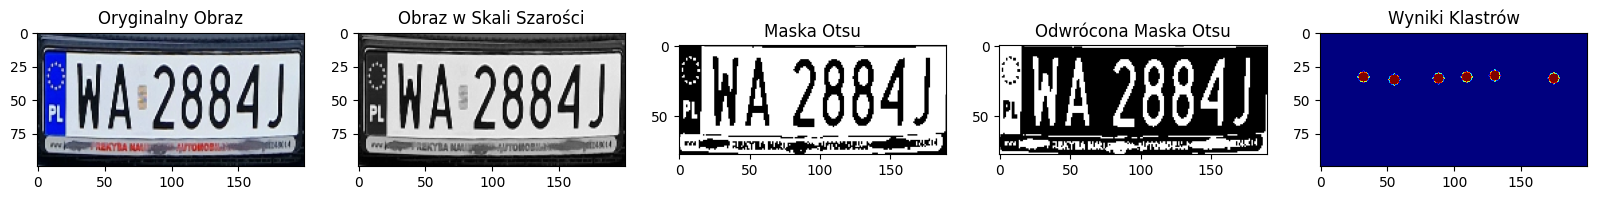

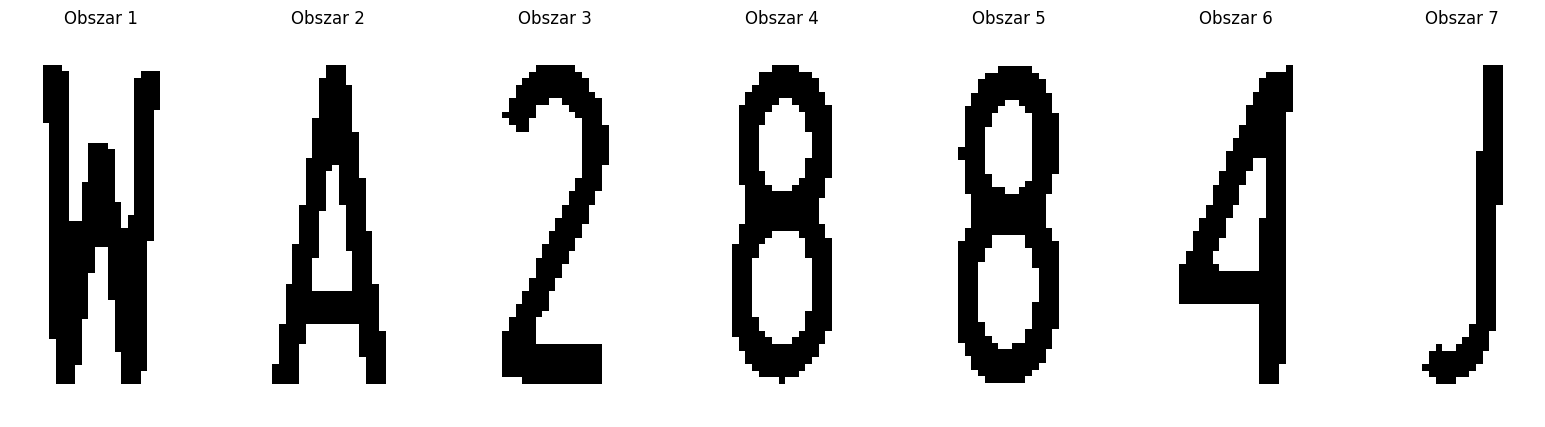

lb 93.3923076923077
area 571
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 589
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 416
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 497
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 391
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 386
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 501
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 262
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 4
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 6
ub 887.2269230769231
mean 933.9230769230769
std 2141.3652532739466

lb 93.3923076923077
area 31
ub 887

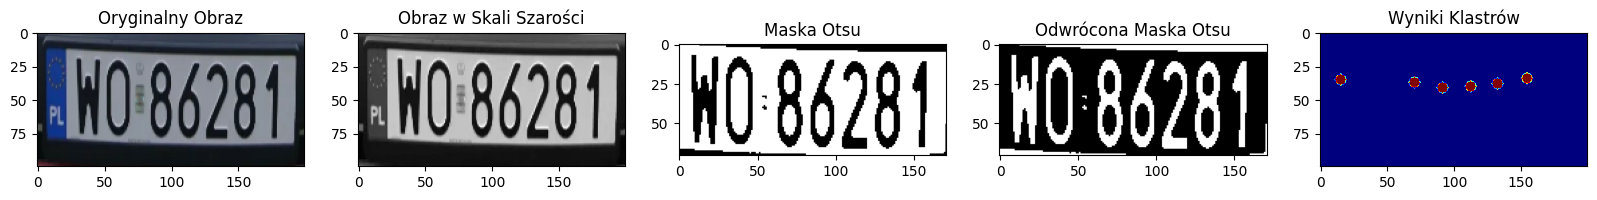

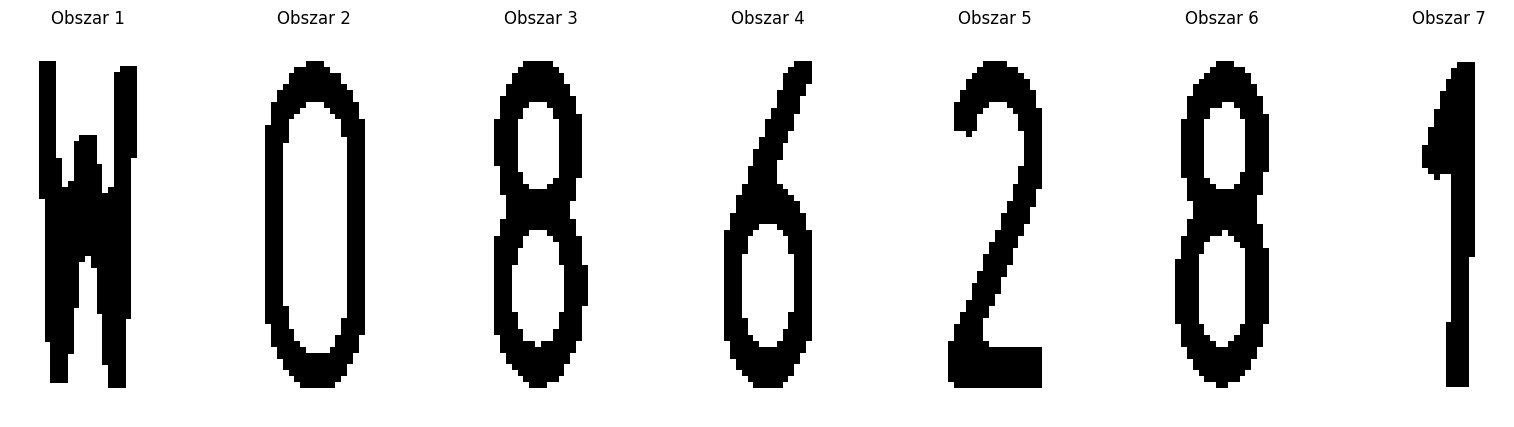

lb 89.22500000000001
area 57
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 1938
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 434
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 302
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 364
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 391
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 284
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 284
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 365
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 304
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 1
ub 847.6374999999999
mean 892.25
std 1872.1462783393824

lb 89.22500000000001
area 47
ub 847.637499999

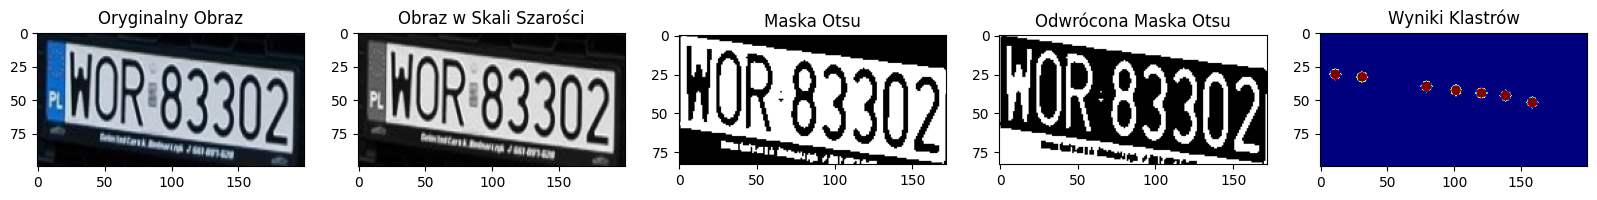

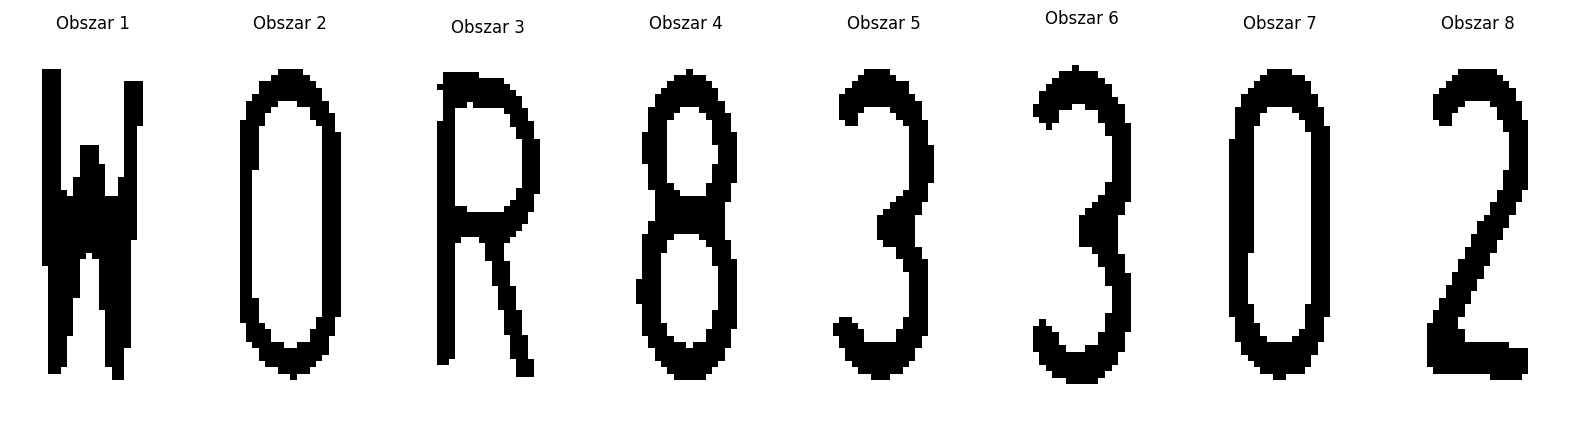

lb 142.85714285714286
area 3787
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 108
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 219
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 248
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 225
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 290
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 400
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 438
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 2
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 142.85714285714286
area 1
ub 1357.142857142857
mean 1428.5714285714287
std 3681.5575840801343

lb 

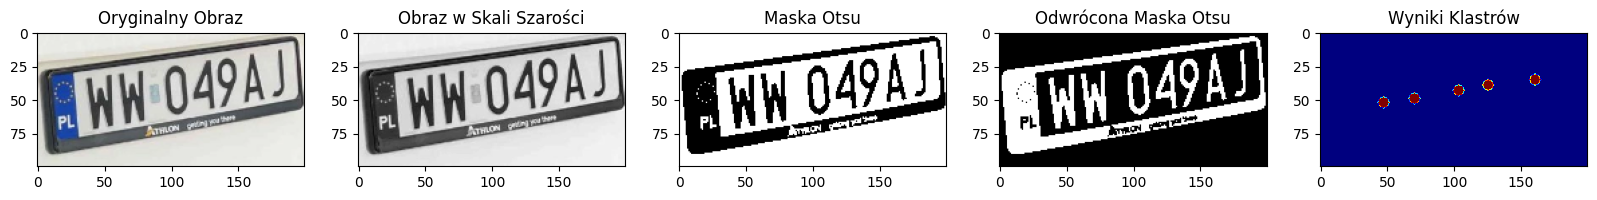

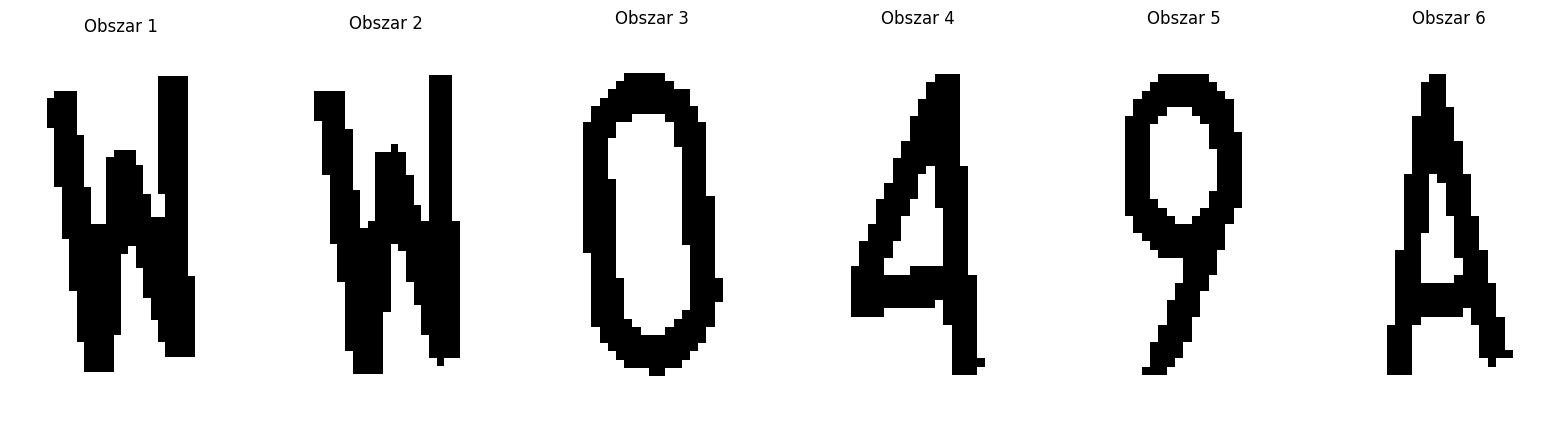

lb 112.58181818181818
area 1122
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 361
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 460
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 281
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 266
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 310
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 307
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 333
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 1330
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228

lb 112.58181818181818
area 15
ub 1069.5272727272727
mean 1125.8181818181818
std 2080.724385146228


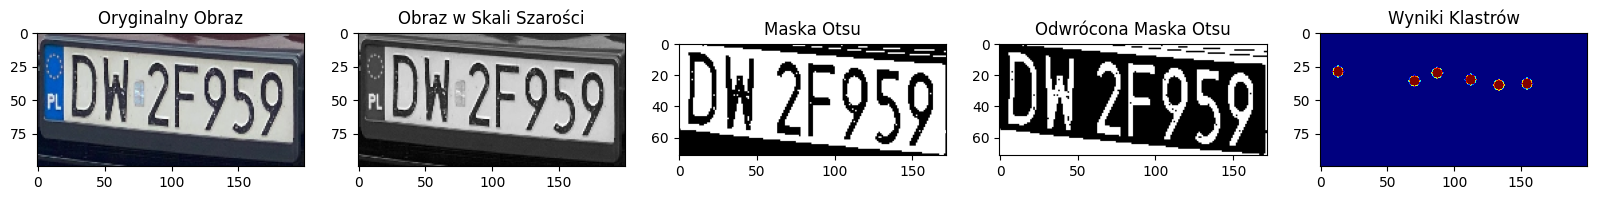

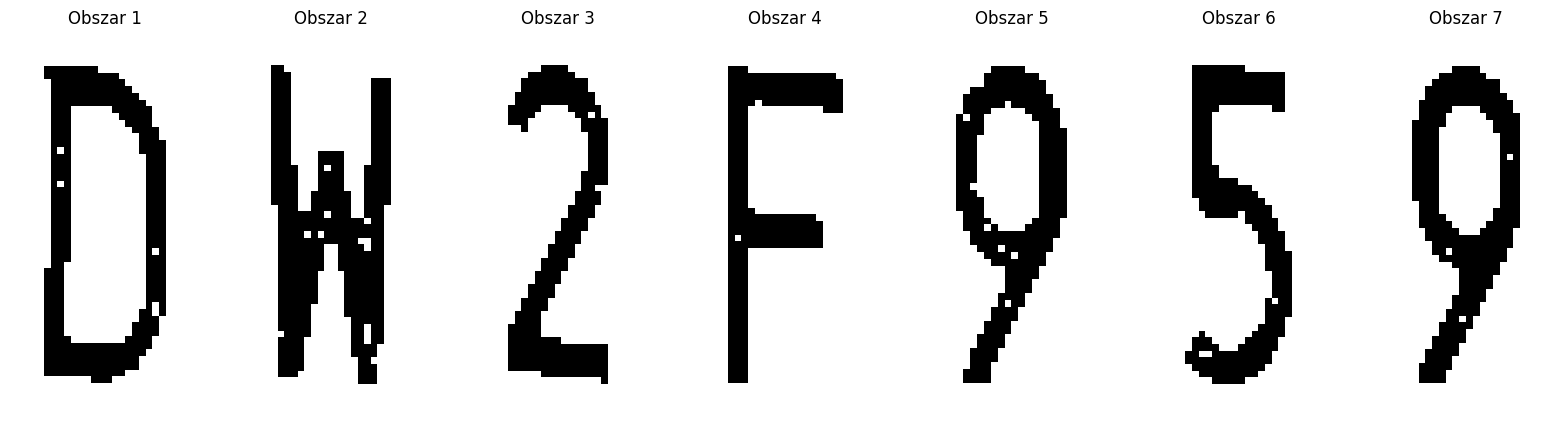

lb 89.0
area 2229
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 1
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 297
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 331
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 315
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 384
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 290
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 374
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 528
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 3
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 2
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 3
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 1
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 57
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 1
ub 845.5
mean 890.0
std 1946.621749414641

lb 89.0
area 2093
ub 845.5
mean 890.0
std 1946.621749414641

better_data/plate/image_08.png


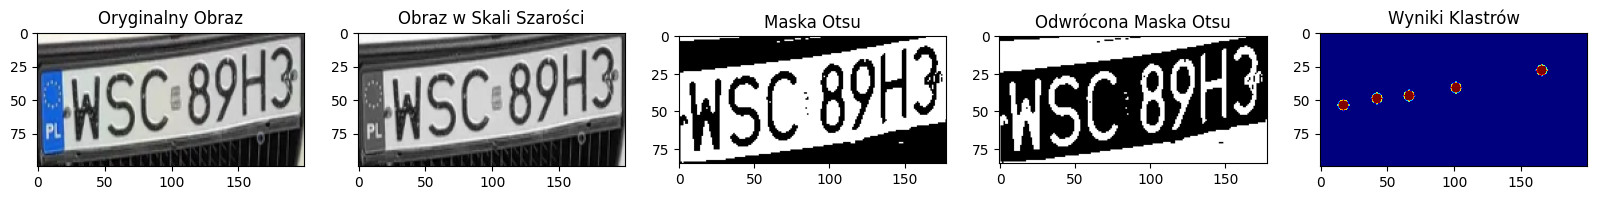

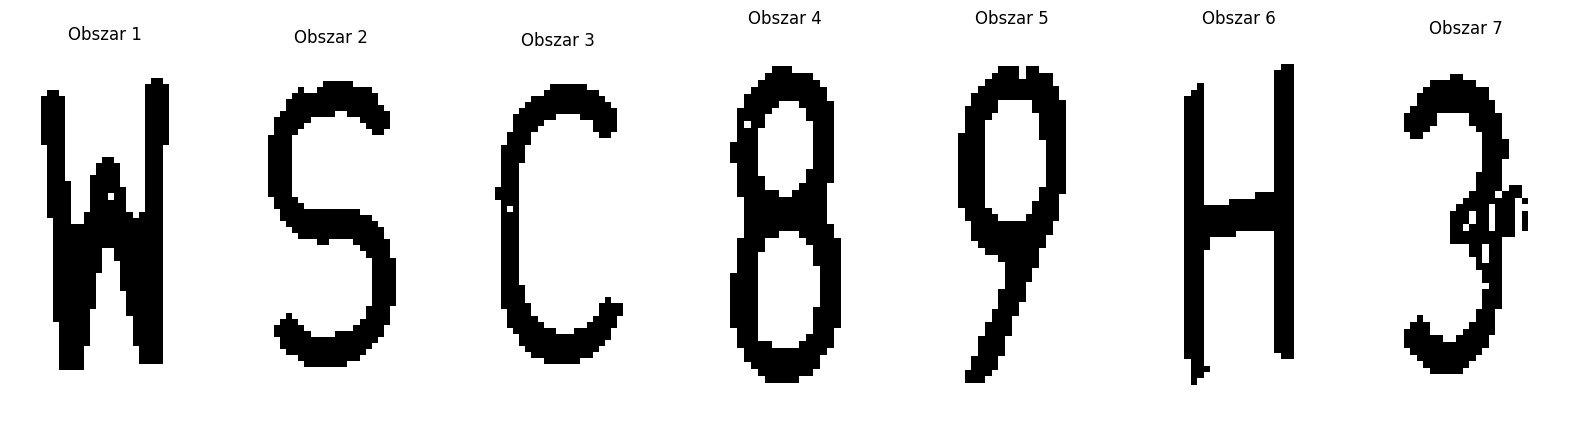

lb 52.35294117647059
area 4
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 13
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 1791
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 1
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 11
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 3
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 1
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 3
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 1
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
area 32
ub 497.35294117647055
mean 523.5294117647059
std 2099.0305077974353

lb 52.35294117647059
are

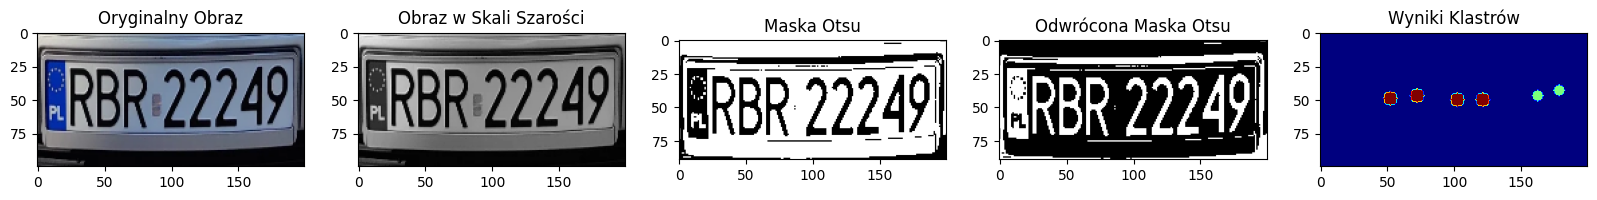

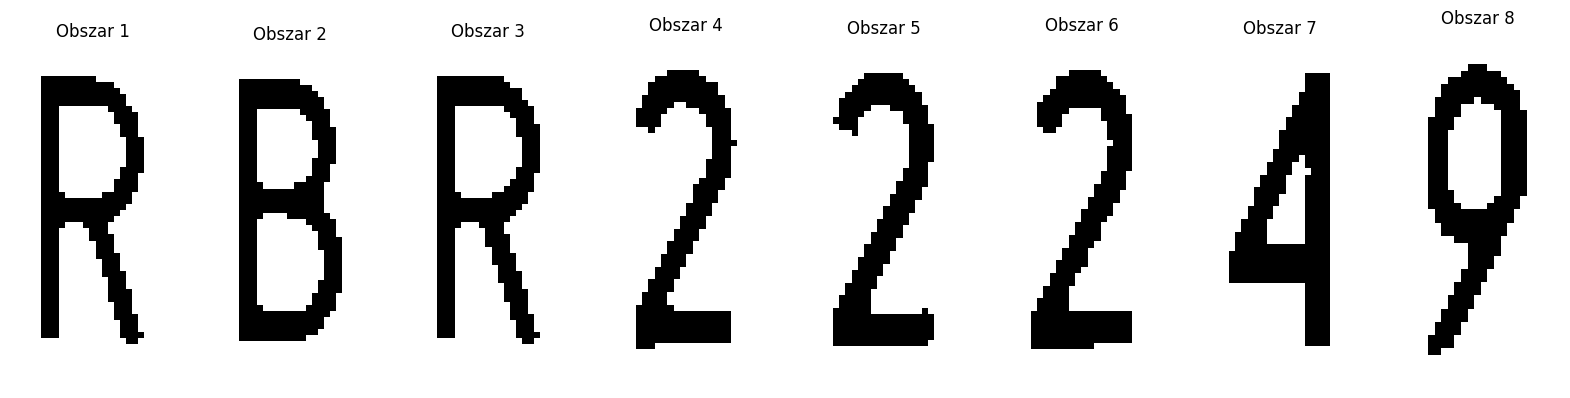

lb 87.51666666666667
area 59
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 2051
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 499
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 356
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 398
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 420
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 319
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 315
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 431
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667
area 348
ub 831.4083333333333
mean 875.1666666666666
std 1983.5587897065773

lb 87.51666666666667

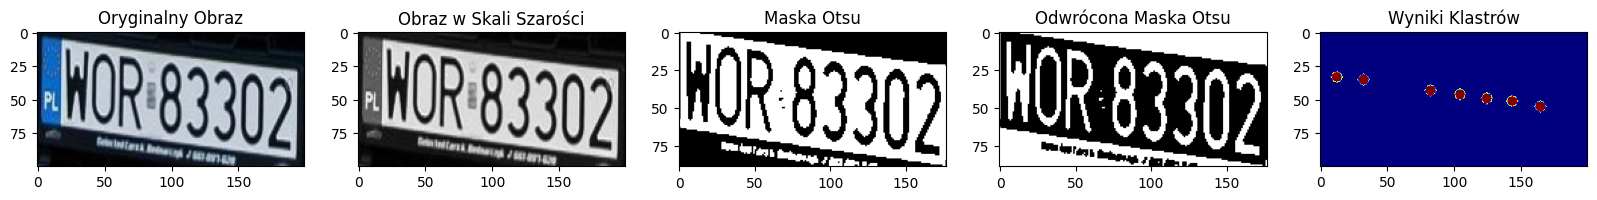

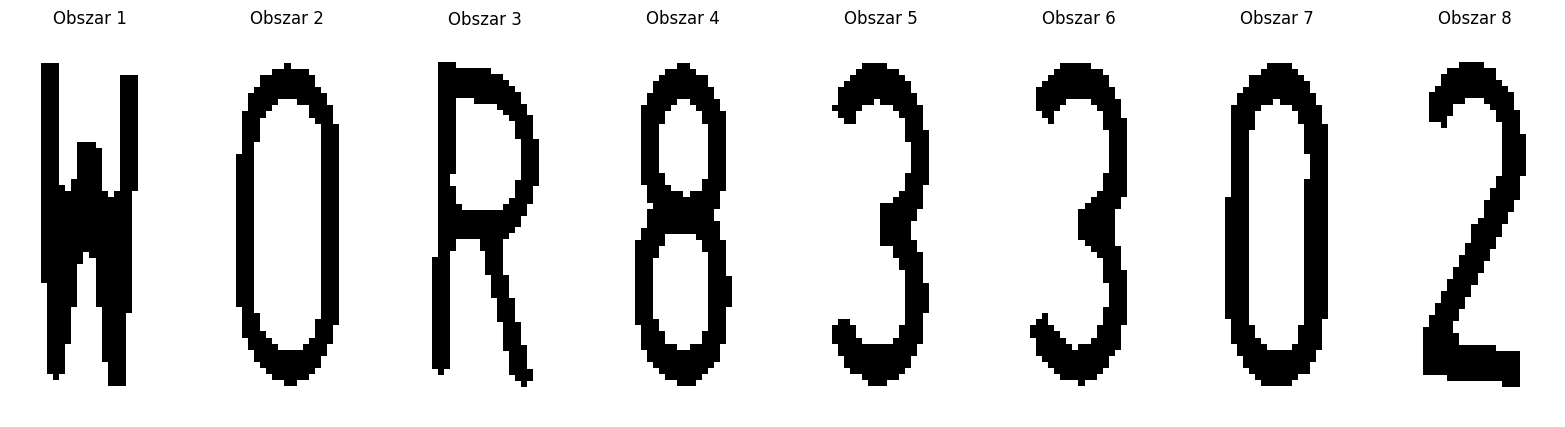

lb 33.675471698113206
area 1670
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 1
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 423
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 468
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 486
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 508
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 421
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 435
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 452
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
area 1
ub 319.9169811320754
mean 336.75471698113205
std 1594.45013773496

lb 33.675471698113206
a

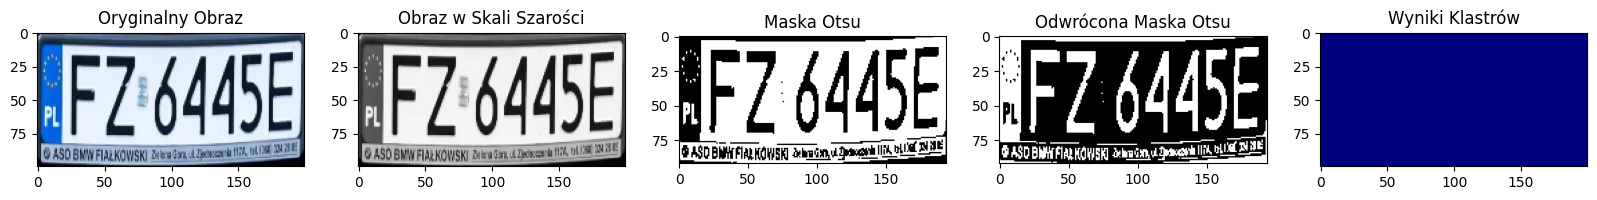

<Figure size 2000x500 with 0 Axes>

lb 123.11666666666667
area 36
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 852
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 430
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 492
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 282
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 346
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 389
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 451
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 419
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855199254

lb 123.11666666666667
area 61
ub 1169.6083333333333
mean 1231.1666666666667
std 2842.6373855

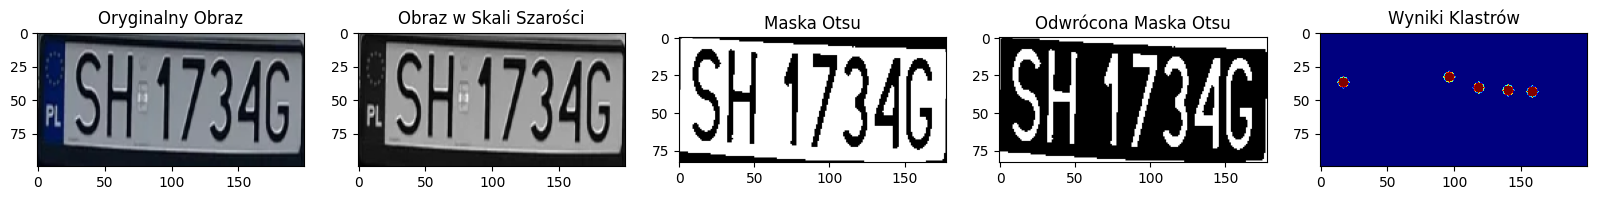

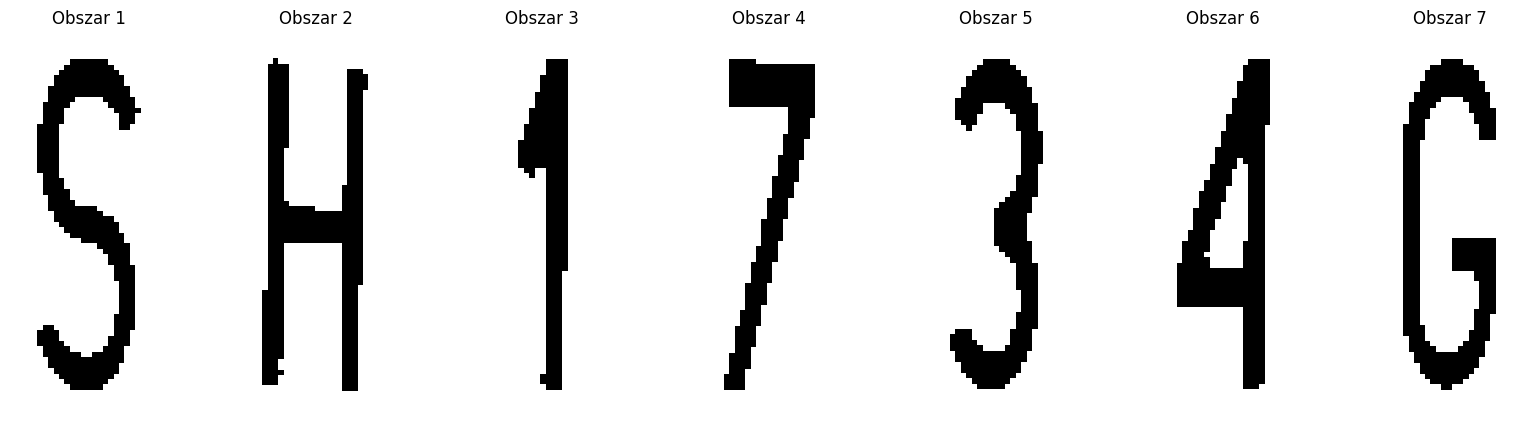

lb 95.46666666666667
area 704
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 330
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 337
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 337
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 437
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 313
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 230
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 225
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 176
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667
area 158
ub 906.9333333333333
mean 954.6666666666666
std 2163.8972685617236

lb 95.46666666666667

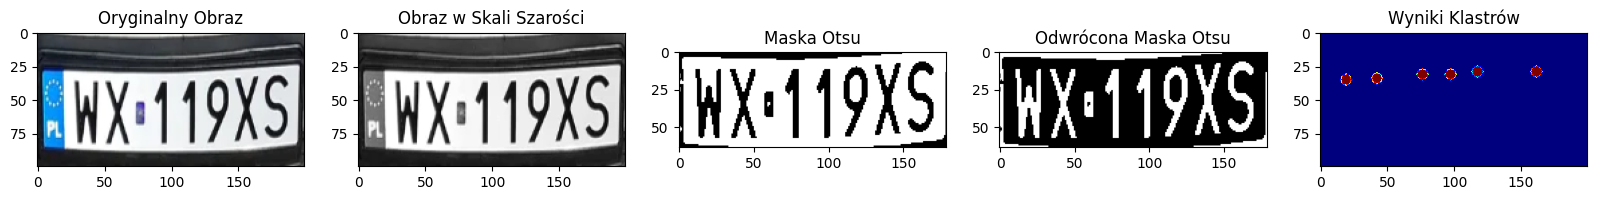

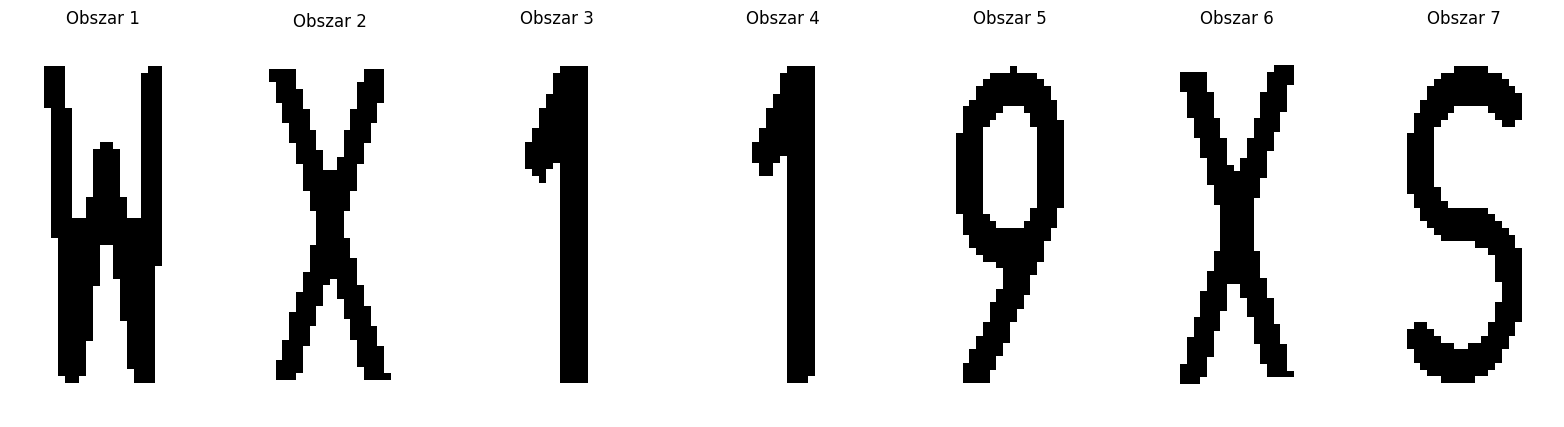

In [147]:
folder_path = 'better_data/plate'
if os.path.exists(folder_path):
    # Pobranie listy plików w folderze
    image_files = [file for file in os.listdir(folder_path) if file.endswith('.png')]
    for image_file in image_files:
        # Tworzenie pełnej ścieżki do pliku
        image_path = os.path.join(folder_path, image_file)
        
        # Wywołanie funkcji process_image dla każdego obrazu
        process_image(image_path, save_crops=True, visualize=True)
else:
    print("Podana ścieżka do folderu nie istnieje.")